# Importando Bibliotecas

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

import pickle

import warnings
warnings.filterwarnings('ignore')

# Lendo os Dados

In [2]:
train_label = pd.read_csv('../data/train_labels.csv')

In [3]:
df = pd.read_csv('../data/train_data.csv')

In [4]:
df = df.groupby('customer_ID').tail(1)
df.reset_index(drop=True, inplace=True)

In [5]:
df = df.merge(train_label, how='left', left_on='customer_ID', right_on='customer_ID')
df

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,...,NaN,NaN,0.007186,0.004234,0.005086,NaN,0.005810,0.002970,0.008533,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,...,NaN,NaN,0.002980,0.007479,0.007870,NaN,0.003284,0.003169,0.008514,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,0.880875,0.009704,0.004284,0.812650,0.006450,NaN,0.003796,0.007196,...,NaN,NaN,0.007383,0.006623,0.000964,NaN,0.002202,0.000834,0.003444,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,0.621776,0.001083,0.012564,1.006183,0.007829,0.287766,0.004532,0.009937,...,NaN,NaN,0.002704,0.006184,0.001899,NaN,0.008183,0.005560,0.002983,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,0.871900,0.005573,0.007679,0.815746,0.001247,NaN,0.000231,0.005528,...,NaN,NaN,0.002974,0.004162,0.005764,NaN,0.008154,0.006944,0.000905,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2018-03-31,0.844229,0.447585,0.028515,1.009867,0.001928,0.128707,0.003482,0.005893,...,NaN,NaN,0.007917,0.001520,0.005530,NaN,0.001430,0.003009,0.004843,0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-03-22,0.831279,0.033670,0.292360,0.055656,0.006953,NaN,0.005791,0.233078,...,NaN,NaN,0.004393,0.006185,0.001480,NaN,0.004794,0.009230,0.006435,0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2018-03-07,0.800522,0.267018,0.020563,1.007023,0.000957,0.066648,0.007424,0.006314,...,NaN,NaN,0.006035,0.002869,0.002149,NaN,0.008031,0.000340,0.002148,0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,2018-03-23,0.754129,0.008619,0.015838,0.714486,0.000993,0.408849,0.003392,0.050048,...,NaN,NaN,1.009894,0.004478,0.949723,0.446255,1.009310,0.002502,0.185527,1


# Feature Engineering

### Droping

In [6]:
useless_columns = ['customer_ID', 'S_2', 'S_3','D_42','D_43','D_46','D_49','D_50','D_53','S_7','D_56','S_9','B_17','D_66','D_73','D_76','D_77','R_9','D_82','B_29','D_87','D_88','D_105','D_106','R_26','D_108','D_110','D_111','B_39','S_27','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142']
df.drop(useless_columns, axis=1, inplace=True)
df

,P_2,D_39,B_1,B_2,R_1,D_41,B_3,D_44,B_4,D_45,...,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target
0,0.934745,0.009119,0.009382,1.007647,0.006104,0.001604,0.007174,0.003258,0.070793,0.740102,...,0.005702,0.006210,0.002715,0.007186,0.004234,0.005086,0.005810,0.002970,0.008533,0
1,0.880519,0.178126,0.034684,1.004028,0.006911,0.005552,0.005068,0.008781,0.020626,0.266275,...,0.001928,0.002996,0.001701,0.002980,0.007479,0.007870,0.003284,0.003169,0.008514,0
2,0.880875,0.009704,0.004284,0.812650,0.006450,0.003796,0.007196,0.000628,0.031044,0.251598,...,0.003470,0.009881,0.007691,0.007383,0.006623,0.000964,0.002202,0.000834,0.003444,0
3,0.621776,0.001083,0.012564,1.006183,0.007829,0.004532,0.009937,0.007792,0.007235,0.085103,...,0.004576,0.001789,0.005140,0.002704,0.006184,0.001899,0.008183,0.005560,0.002983,0
4,0.871900,0.005573,0.007679,0.815746,0.001247,0.000231,0.005528,0.002436,0.269407,0.069952,...,0.008897,0.005045,0.003706,0.002974,0.004162,0.005764,0.008154,0.006944,0.000905,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,0.844229,0.447585,0.028515,1.009867,0.001928,0.003482,0.005893,0.002280,0.058313,0.073120,...,0.009489,0.002072,0.004589,0.007917,0.001520,0.005530,0.001430,0.003009,0.004843,0
458909,0.831279,0.033670,0.292360,0.055656,0.006953,0.005791,0.233078,0.132158,0.248441,0.618023,...,1.006120,1.128725,0.004884,0.004393,0.006185,0.001480,0.004794,0.009230,0.006435,0
458910,0.800522,0.267018,0.020563,1.007023,0.000957,0.007424,0.006314,0.001022,0.079597,0.133731,...,0.003282,0.004513,0.008924,0.006035,0.002869,0.002149,0.008031,0.000340,0.002148,0
458911,0.754129,0.008619,0.015838,0.714486,0.000993,0.003392,0.050048,0.133062,0.237388,0.070383,...,0.002679,0.000479,0.006828,1.009894,0.004478,0.949723,1.009310,0.002502,0.185527,1


### Column Transformer

In [7]:
cat_data = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']
cat_transformer = OneHotEncoder(handle_unknown='ignore')

In [8]:
numeric_data = ['P_2','D_39','B_1','B_2','R_1','D_41','B_3','D_44','B_4','D_45','B_5','R_2','D_47','D_48','B_6','B_7','B_8','D_51','B_9','R_3','D_52','P_3','B_10','S_5','B_11','S_6','D_54','R_4','B_12','S_8','D_55','B_13','R_5','D_58','B_14','D_59','D_60','D_61','B_15','S_11','D_62','D_65','B_16','B_18','B_19','B_20','S_12','R_6','S_13','B_21','D_69','B_22','D_70','D_71','D_72','S_15','B_23','P_4','D_74','D_75','B_24','R_7','B_25','B_26','D_78','D_79','R_8','S_16','D_80','R_10','R_11','B_27','D_81','S_17','R_12','B_28','R_13','D_83','R_14','R_15','D_84','R_16','S_18','D_86','R_17','R_18','B_31','S_19','R_19','B_32','S_20','R_20','R_21','B_33','D_89','R_22','R_23','D_91','D_92','D_93','D_94','R_24','R_25','D_96','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_36','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_127','D_128','D_129','B_41','D_130','D_131','D_133','R_28','D_139','D_140','D_141','D_143','D_144','D_145']
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator=LinearRegression(), max_iter=30, imputation_order='roman')),
    ('pca', PCA(n_components=20))
    ])

In [9]:
transformer = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_data),
    ('num', numeric_transformer, numeric_data)
    ])

### Train Test Split

In [10]:
X = df.drop(['target'], axis=1)
y = df['target']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

### Scoring

In [12]:
def amex_metric(y_true, y_pred):
    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

In [13]:
metric = metrics.make_scorer(amex_metric)

### Class Weight

In [14]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.6748321527305117, 1: 1.9299429258035445}

# Pipeline

In [15]:
modelos = [RandomForestClassifier(class_weight=class_weights), LogisticRegression(class_weight=class_weights), LGBMClassifier(class_weight=class_weights), CatBoostClassifier(class_weights=class_weights)]

In [16]:
skf = StratifiedKFold(n_splits=5)

In [17]:
for modelo in modelos:
    pipe = Pipeline(steps=[
        ('preprocessor', transformer),
        ('model', modelo)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring=metric)
    print(f'''
          Modelo: {modelo} CV AMEX Score: {scores.mean()*100} +/- {scores.std()*100}'
          ''')


          Modelo: RandomForestClassifier(class_weight={0: 0.6748321527305117,
                                     1: 1.9299429258035445}) CV AMEX Score: 52.946212556586424 +/- 0.5843954988756999%'
          

          Modelo: LogisticRegression(class_weight={0: 0.6748321527305117, 1: 1.9299429258035445}) CV AMEX Score: 49.34586527120334 +/- 0.5581110275296403%'
          

          Modelo: LGBMClassifier(class_weight={0: 0.6748321527305117, 1: 1.9299429258035445}) CV AMEX Score: 49.15509611983502 +/- 0.5159593864131518%'
          
Learning rate set to 0.110146
0:	learn: 0.5985497	total: 123ms	remaining: 2m 3s
1:	learn: 0.5273201	total: 202ms	remaining: 1m 41s
2:	learn: 0.4755789	total: 283ms	remaining: 1m 34s
3:	learn: 0.4371515	total: 364ms	remaining: 1m 30s
4:	learn: 0.4103329	total: 520ms	remaining: 1m 43s
5:	learn: 0.3877175	total: 606ms	remaining: 1m 40s
6:	learn: 0.3725588	total: 681ms	remaining: 1m 36s
7:	learn: 0.3587251	total: 799ms	remaining: 1m 39s
8:	learn: 0.3495173	t

# Random Forest Classifier

In [18]:
pipeline = Pipeline(steps=[
        ('preprocessor', transformer),
        ('model', RandomForestClassifier(class_weight=class_weights))
    ])

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B_30', 'B_38', 'D_114',
                                                   'D_116', 'D_117', 'D_120',
                                                   'D_126', 'D_63', 'D_64',
                                                   'D_68']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(estimator=LinearRegression(),
                                                                                    imputation_order='roman',
                                                                                    max_iter=30)),
                                                                  ('pca',
                                                                   PCA(n_components=20))]),
                                                  ['P_2', 'D_39', 'B_1', 'B_2',
                                                   'R_1', 'D_41', 'B_3', 'D_44',
                                                   'B_4', 'D_45', 'B_5', 'R_2',
                                                   'D_47', 'D_48', 'B_6', 'B_7',
                                                   'B_8', 'D_51', 'B_9', 'R_3',
                                                   'D_52', 'P_3', 'B_10', 'S_5',
                                                   'B_11', 'S_6', 'D_54', 'R_4',
                                                   'B_12', 'S_8', ...])])),
                ('model',
                 RandomForestClassifier(class_weight={0: 0.6748321527305117,
                                                      1: 1.9299429258035445}))])

In [31]:
y_pred_test = pipeline.predict(X_test)

accuracy = round(metrics.accuracy_score(y_test, y_pred_test)*100,2)

precision = round(metrics.precision_score(y_test, y_pred_test)*100,2)

recall = round(metrics.recall_score(y_test, y_pred_test)*100,2)

f1_score = round(metrics.f1_score(y_test, y_pred_test)*100,2)

amex = round(amex_metric(y_test, y_pred_test),2)

print(f'''
      As métricas do teste foram:
      Acurária = {accuracy}%
      Precisão = {precision}%
      Recall = {recall}%
      F1 Score = {f1_score}%
      AMEX Score = {amex}
      ''')


      As métricas do teste foram:
      Acurária = 88.36%
      Precisão = 79.41%
      Recall = 74.26%
      F1 Score = 76.75%
      AMEX Score = 0.52
      


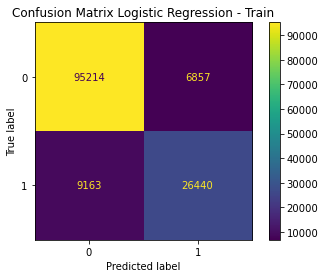

In [26]:
cm = metrics.confusion_matrix(y_test, y_pred_test)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix Logistic Regression - Train')
plt.show()

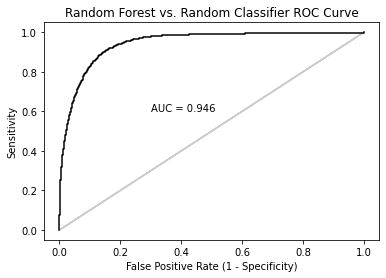

In [32]:
modelo_probabilidades = pipeline.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = metrics.roc_curve(y_test, modelo_probabilidades, pos_label=1)
auc = round(metrics.roc_auc_score(y_test, modelo_probabilidades),3)

plt.step(false_positive_rate_values, sensitivity_values, color='black', where='post')
plt.step(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001), color='black', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('Random Forest vs. Random Classifier ROC Curve')
plt.annotate(f'AUC = {auc}', xy=(0.3, 0.6))

plt.show()

# Exportando o Modelo

In [35]:
pickle.dump(cat_data, open('../models/cat_data.pkl', 'wb'))
pickle.dump(cat_transformer, open('../models/cat_transformer.pkl', 'wb'))
pickle.dump(numeric_data, open('../models/numeric_data.pkl', 'wb'))
pickle.dump(numeric_transformer, open('../models/numeric_transformer.pkl', 'wb'))
pickle.dump(transformer, open('../models/transformer.pkl', 'wb'))
pickle.dump(metric, open('../models/metric.pkl', 'wb'))
pickle.dump(pipeline, open('../models/pipeline.pkl', 'wb'))